In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from google.colab import userdata
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
from tqdm import tqdm

## Why DenseNet?

**Simple Explanation of DenseNet**

DenseNet connects each layer to every subsequent layer. For example, the lth layer takes inputs from all previous layers (l-1, l-2, ...). So, if there are L layers, there would be L(L+1)/2 connections, while traditional ConvNets only have L connections.

**Advantages of DenseNet**

* Parameter Efficiency: DenseNet requires fewer parameters than traditional convolutional networks, as feature maps are reused throughout the network. This avoids the need to learn redundant features repeatedly.
* Strong Gradient Flow: DenseNets have improved flow of information and gradients throughout the network. Each layer has direct access to the gradients from the loss function and the original input signal, leading to implicit deep supervision. This helps train deeper network architectures and has a regularizing effect, reducing overfitting on tasks with smaller training set sizes.


This is an implementation of DenseNet-BC with settings of {L=121, k=32}, as shown in Table 1 of the paper. Let's break down the key components:


## Create DenseNet Model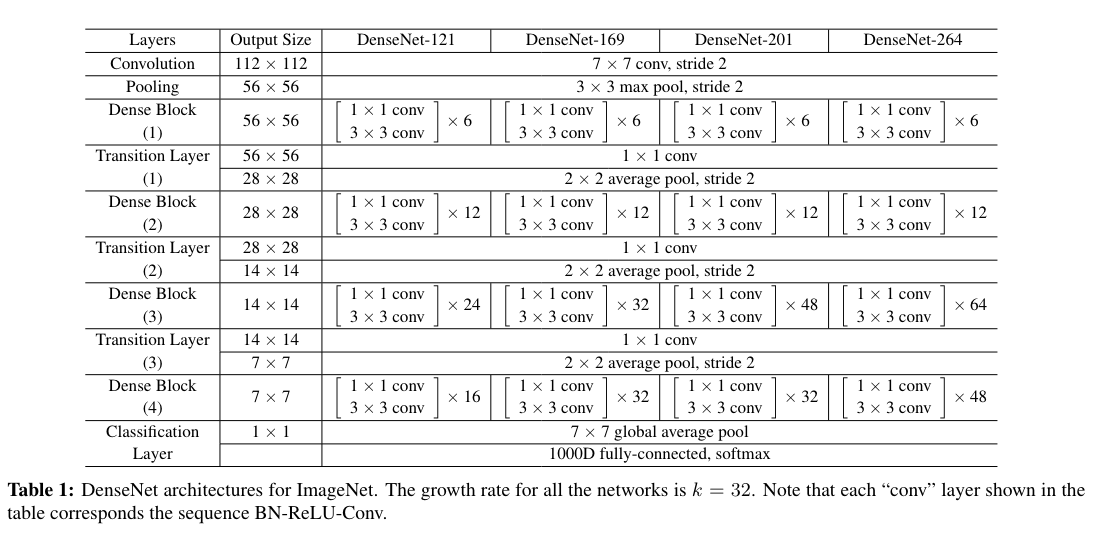

### Densenet Block

Each layer within a DenseBlock follows the pattern: BN-ReLU-Conv(1x1)-BN-ReLU-Conv(3x3). The Conv(1x1) layer serves as a bottleneck layer, designed to reduce the number of feature maps before the computationally expensive Conv(3x3) layer.


* Growth Rate (k): This hyperparameter controls the number of feature maps produced by each layer. In our case, k=32, so each Conv(3x3) layer outputs 32 feature maps. The Conv(1x1) layer outputs 4k (128) feature maps to provide sufficient input for the subsequent Conv(3x3).
* Initial Convolution: The very first convolution layer outside the DenseBlocks is set to produce 16 feature maps, as recommended in the paper (either 16 or 2k).

Each Layer in DesneBlock is like this
BN-ReLU-Conv(1X1)-BN-ReLU-Conv(3X3)

As the author of the paper said I set the Conv(1X1) layer to create 4k feature maps and the Conv(3X3) creates k feature maps.

Here k is growth rate which detemins how ma

In [110]:
class DenseBlock(nn.Module):
  def __init__(self, num_layers, inital_channels, growth_rate=32):
    super(DenseBlock, self).__init__()
    self.relu = nn.ReLU(inplace=True)
    self.blocks = nn.ModuleList()
    self.bns = nn.ModuleList()

    for i in range(num_layers):
      input_channel = inital_channels + i*growth_rate
      self.bns.append(nn.BatchNorm2d(num_features=input_channel))
      self.blocks.append(nn.Conv2d(in_channels=input_channel, out_channels=4*growth_rate, kernel_size=1, stride=1, padding=0))
      self.bns.append(nn.BatchNorm2d(num_features=4*growth_rate))
      self.blocks.append(nn.Conv2d(in_channels=4*growth_rate, out_channels=growth_rate, kernel_size=3, stride=1, padding=1))\


  def forward(self, x):
    inputs = [x]
    for i in range(0, len(self.blocks), 2):
      x = torch.cat(inputs, dim=1) # concatenate from x_{0} to x_{l-1}

      x = self.bns[i](x)
      x = F.relu(x)
      x = self.blocks[i](x)
      x = self.bns[i+1](x)
      x = F.relu(x)
      x = self.blocks[i+1](x)
      inputs.append(x)

    return x

In [111]:
dense_block_1 = DenseBlock(num_layers=6, inital_channels=16)
dense_block_2 = DenseBlock(num_layers=12, inital_channels=16)
dense_block_3 = DenseBlock(num_layers=24, inital_channels=16)
dense_block_4 = DenseBlock(num_layers=16, inital_channels=16)

In [112]:
sample_input_1 = torch.rand(1, 16, 56, 56)
output1 = dense_block_1(sample_input_1)
print(output1.shape)

sample_input_2 = torch.rand(1, 16, 28, 28)
output2 = dense_block_2(sample_input_2)
print(output2.shape)

sample_input_3 = torch.rand(1, 16, 14, 14)
output3 = dense_block_3(sample_input_3)
print(output3.shape)

sample_input_4 = torch.rand(1, 16, 7, 7)
output4 = dense_block_4(sample_input_4)
print(output4.shape)

torch.Size([1, 32, 56, 56])
torch.Size([1, 32, 28, 28])
torch.Size([1, 32, 14, 14])
torch.Size([1, 32, 7, 7])


### Transition Layer

Transition layers are crucial for downsampling the feature maps between DenseBlocks. The compression factor (theta, θ) determines the degree of downsampling. Here, θ = 0.5. This means if 'm' feature maps enter the transition layer, it will output m/2 feature maps.

* Components: A transition layer consists of:
    * A 1x1 convolution layer to reduce the number of channels (feature maps).
    * A 2x2 average pooling layer with a stride of 2 to reduce the spatial dimensions (height and width).


* Compression rate:
 * The compression factor θ can range between 0 (extreme compression) and 1 (no compression).
 * This notebook also 0.5 for θ since paper also used 0.5.

In [113]:
class Transition(nn.Module):
  def __init__(self, input_channel=32):
    super(Transition, self).__init__()
    self.conv = nn.Conv2d(in_channels=input_channel, out_channels=input_channel//2, kernel_size=1, stride=1, padding=0)
    self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    x = self.conv(x)
    x = self.pool(x)
    return x

In [114]:
trans1 = Transition()
input_tensor = torch.randn(1, 32, 56, 56)
output = trans1(input_tensor)
print(output.shape)

torch.Size([1, 16, 28, 28])


### Putting all together

DenseNet consists of multiple Dense Blocks, each followed by a Transition Layer, forming the core of the architecture.

In [115]:
class DenseNet(nn.Module):
  def __init__(self):
    super(DenseNet, self).__init__()
    self.conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=7, stride=2, padding=3)
    self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.dense_block_1 = DenseBlock(num_layers=6, inital_channels=16)
    self.trans_layer_1 = Transition()
    self.dense_block_2 = DenseBlock(num_layers=12, inital_channels=16)
    self.trans_layer_2 = Transition()
    self.dense_block_3 = DenseBlock(num_layers=24, inital_channels=16)
    self.trans_layer_3 = Transition()
    self.dense_block_4 = DenseBlock(num_layers=16, inital_channels=16)
    self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(32, 200)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = self.conv(x)
    x = self.max_pool(x)
    x = self.dense_block_1(x)
    x = self.trans_layer_1(x)
    x = self.dense_block_2(x)
    x = self.trans_layer_2(x)
    x = self.dense_block_3(x)
    x = self.trans_layer_3(x)
    x = self.dense_block_4(x)
    x = self.global_avg_pool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)
    return x

Example inference

In [116]:
model = DenseNet()
input_tensor = torch.randn(32, 3, 224, 224)
output = model(input_tensor)
print(output.shape)

torch.Size([32, 200])


In [117]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params}")

Total Parameters: 4277752
